## File loading

In [1]:
import numpy as np 
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from IPython.display import FileLink
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import copy
import glob
import sys
import os
import shutil

warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
%%capture
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:

try:
    df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv', delimiter=',')
except FileNotFoundError as e:
    print(f"Error: {e}")
    

# A basic overview of the NIH chest x-ray data.

We will use some exploratory functions to see what this data looks like.
head(), describe().

In [ ]:
df.head()

In [ ]:
df.describe()

## Data cleaning and preprocessing

In [ ]:
column_list = df.columns.tolist()
print(column_list)

In [ ]:
# Split the 'Findings' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# This will give you a new column 'Conditions' where each entry is a list of conditions

df['Num Conditions'] = df['Conditions'].apply(len)

df_exploded = df.explode('Conditions')

In [ ]:
# Split the 'Finding Labels' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# Convert the list of conditions to a string
df['Conditions'] = df['Conditions'].apply(lambda x: ' '.join(x))

# Create dummy variables for each condition
condition_dummies = df['Conditions'].str.get_dummies(sep=' ')

# Concatenate the original DataFrame with the dummy DataFrame
df = pd.concat([df, condition_dummies], axis=1)

From calling df.head() we can see that the conditions are listed in the column 'Finding Label' which we can extract.

In [ ]:
df.head()

Split the 'Finding Labels' colmumn into separate conditions.

In [ ]:
# Select relevant columns
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# Make sure the labels are of the string type
df['Finding Labels'] = df['Finding Labels'].astype(str)

# Split the labels into the different conditions
df['Finding Labels'] = df['Finding Labels'].str.split('|')

# The list of conditions
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Create new columns for each disease
def create_disease_columns(dataframe, pathology_list):
    for pathology in pathology_list:
        dataframe[pathology] = dataframe['Finding Labels'].apply(lambda x: int(pathology in x))
    return dataframe

# Call the function with the dataframe and pathology_list
df = create_disease_columns(df, pathology_list)

In [ ]:
df.tail()

In [ ]:
# Drop the 'Finding Labels' column
df = df.drop('Finding Labels', axis=1)

In [ ]:
df.tail()

In [ ]:
# Create a histogram of the 'Patient Age' column
plt.figure(figsize=(10,6))
plt.hist(df['Patient Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Age')

# Display the plot
plt.show()

We can see that a majority of the patients are between the ages of 0 and 100. There are a few that are above 100 years old and  of those were above the current record of 122 years old. We can look deeper into this and make changes as there is a high chance that those are errors.

In [ ]:
# Create a boolean mask for ages greater than 100
mask = df['Patient Age'] > 100

# Use the mask to filter the DataFrame
filtered_df = df[mask]

# Get the number of rows in the filtered DataFrame
num_persons = filtered_df.shape[0]

print(num_persons)

In [ ]:
# Create a boolean mask for ages less than or equal to 100
mask = df['Patient Age'] <= 100

# Use the mask to filter the DataFrame
df = df[mask]

After removing the patients with ages above the current record of 122 years old, we can visualise the age distribution again.

In [ ]:
# Create a histogram of the 'Patient Age' column
plt.figure(figsize=(10,6))
plt.hist(df['Patient Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Age')

# Display the plot
plt.show()

In [ ]:
# Loop through the conditions and print their sum total in the data
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

for condition in pathology_list:
    print(f"{condition}: {df[condition].sum()}")

In [ ]:
# Set the default palette
sns.set_palette('viridis')

# Create a list to store the counts of each condition
condition_counts = [df[pathology].sum() for pathology in pathology_list]

# Create a DataFrame from the condition counts
data = pd.DataFrame({
    'Condition': pathology_list,
    'Count': condition_counts
})

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(y='Condition', x='Count', data=data)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Condition')
plt.title('Count of Each Condition in the Dataset')

# Display the chart
plt.show()

## Chest x-rays with findings vs no findings.

We can see that approximately 54% of the chest x-rays in this dataset are labelled as having no findings, this can present challenges or learning opportunities depending on what we want to do with our data.
We may want to know what features differentiate those with no findings from those with findings. 

For machine learning we may want to take measures to ensure having a large number of ‘No Finding’ images does not bias the model towards predicting ‘No Finding'.

In [ ]:
# Create age groups
bins = list(range(0, 101, 10))  # Creates bins from 0 to 130 with a step of 10
labels = [f'{i}-{i+9}' for i in range(0, 100, 10)]  # Creates labels for these bins
df['Age Group'] = pd.cut(df['Patient Age'], bins=bins, labels=labels, right=False)

# Calculate % of total per age group
total_patients = df.shape[0]
df_total = df['Age Group'].value_counts().sort_index() / total_patients * 100

# Calculate % of no findings per age group
df_no_findings = df[df['No Finding'] == 1].groupby('Age Group').size() / df.groupby('Age Group').size() * 100

# Combine both series into a dataframe
age_analysis_df = pd.concat([df_total, df_no_findings], axis=1)
age_analysis_df.columns = ['% of Total', '% of No Findings']

# Print the dataframe
print(age_analysis_df)

We see that there the trend is for the number of x-rays with 'No findings' to decrease with age. About 50.4% of those <10 have no finding dropping off to 28.4% with no findings in the nineties, this is in keeping with what we may expect as health issues tend to increase with age.

In [ ]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot % of Total
age_analysis_df['% of Total'].plot(kind='bar', color='blue', ax=ax1, width=0.3, position=1)
ax1.set_ylabel('% of age group in Total Dataset', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the same plot
ax2 = ax1.twinx()

# Plot % of No Findings on the second y-axis
age_analysis_df['% of No Findings'].plot(kind='bar', color='red', ax=ax2, width=0.3, position=0)
ax2.set_ylabel('% of age group with No Findings', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the x-axis label
ax1.set_xlabel('Age Group')

# Set the plot title
plt.title('Percentages of Total and No Findings per Age Group')

# Show the plot
plt.show()

In [ ]:
# Calculate the statistical summary for 'Follow-up #' for each age group
follow_up_summary = df.groupby('Age Group', observed=True)['Follow-up #'].describe()

print(follow_up_summary)

Patient gender doesn't seem to have much on an impact on wether there are findings or not. This may not be surprising information.

In [ ]:
gender_analysis = df.groupby('Patient Gender')['No Finding'].mean()
print(gender_analysis)

In [ ]:
# Set the color palette
sns.set_palette('viridis')

# Create a bar plot
plt.figure(figsize=(12,6))
gender_analysis.plot(kind='bar')

# Set the plot labels and title
plt.xlabel('Patient Gender')
plt.ylabel('Proportion of No Finding')
plt.title('Proportion of No Finding Results by Gender')

# Show the plot
plt.show()

In [ ]:
df.columns

In [ ]:
# Load the images
root_folder = "/kaggle/input/data/"

# Use glob to get all PNG images from the subfolders
try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")

In [ ]:
# Select 6 random pathologies
selected_pathologies = np.random.choice(pathology_list[1:], 6, replace=False)  # Exclude 'No Finding'

# Select one image from each selected pathology
other_pathology_images = [df[df[pathology] == 1].sample(1)['Image Index'].values[0] for pathology in selected_pathologies]

# Set aside 6 images from 'No Finding'
no_finding_images = df[df['No Finding'] == 1].sample(6)['Image Index'].values

# Now you have 6 images from 'No Finding' and 1 from each of the 6 selected pathologies
selected_images = list(no_finding_images) + other_pathology_images

image_paths_dict = {os.path.basename(path): path for path in image_paths}

# Create a figure with subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

for i, img_name in enumerate(selected_images):
    # Load the image
    img_path = image_paths_dict[img_name]
    img = mpimg.imread(img_path)
    
    # Find the corresponding pathology
    pathology = df[df['Image Index'] == img_name][pathology_list].idxmax(axis=1).values[0]
    
    # Display the image in a subplot
    ax = axes[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(pathology)

# Remove empty subplots
if len(selected_images) < 12:
    for i in range(len(selected_images), 12):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

# Problem scope reduction

We will reduce the scope of the problem to train the model to classify 5 common conditions. 

We will use a maximum of 3000 images per condition (this helped to reduce the number of files required).

In [ ]:
df.head()

In [ ]:
# Load the images
root_folder = "/kaggle/input/data/"

In [ ]:
try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")

In [ ]:
df.tail()

No Finding: 60353
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2302
Effusion: 13316
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19891
Mass: 5779
Nodule: 6331
Pleural_Thickening: 3384
Pneumonia: 1430
Pneumothorax: 5301

In [ ]:
# Define the desired counts for each condition
desired_counts = {'No Finding': 2, 'Consolidation': 1, 'Infiltration': 1, 'Effusion': 1, 'Nodule': 1}

# Get the list of all image paths
try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")

selected_images = []

# For each condition
for label, count in desired_counts.items():
    # Sample the desired number of images for this condition
    condition_images = df[df[label] == 1].sample(min(count, 3000))['Image Index'].values
    selected_images.extend(condition_images)

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for i, img_name in enumerate(selected_images):
    img_path = [path for path in image_paths if img_name in path][0]  # Find the corresponding image path using img_name
    img = mpimg.imread(img_path)
    
    # Get the condition(s) for this image
    conditions = df.columns[(df.loc[df['Image Index'] == img_name] == 1).values[0]]
    
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(', '.join(conditions))

if len(selected_images) < 6:
    for i in range(len(selected_images), 6):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [ ]:
df.tail()

In [ ]:
# Define the condition columns
condition_columns = ['No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Count the number of occurrences for each condition
for column in condition_columns:
    print(f"{column}: {df[column].sum()}")

print(f"Total: {len(df)}")

In [ ]:
# Define the condition columns
condition_columns = ['No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Create a new column 'num_conditions' that is the sum of the condition columns
df['num_conditions'] = df[condition_columns].sum(axis=1)

# Filter out the rows where 'num_conditions' is greater than 1
df_single_condition = df[df['num_conditions'] <= 1]

# Drop the 'num_conditions' column as it's no longer needed
df_single_condition = df_single_condition.drop(columns='num_conditions')

df_single_condition.tail()

In [ ]:
# Define the condition columns
condition_columns = ['No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Count the number of occurrences for each condition
for column in condition_columns:
    print(f"{column}: {df_single_condition[column].sum()}")

print(f"Total: {len(df_single_condition)}")

In [ ]:
df_single_condition.head()

In [ ]:
max_samples_per_condition = 2000
sampled_dfs = []

# Define the condition columns
condition_columns = ['No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

for label in condition_columns:
    # Get the rows where the current condition is present
    condition_df = df_single_condition[df_single_condition[label] == 1]
    
    # If the number of images for this condition is more than max_samples_per_condition, sample it
    if len(condition_df) > max_samples_per_condition:
        condition_df = condition_df.sample(n=max_samples_per_condition, random_state=42)
    
    sampled_dfs.append(condition_df)

# Concatenate all the dataframes
sampled_df = pd.concat(sampled_dfs, ignore_index=True)

In [ ]:
print(len(sampled_df))

In [ ]:
sampled_df.tail()

In [ ]:
# Load the images
root_folder = "/kaggle/input/data/"

try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")
    

In [ ]:
df = sampled_df

In [ ]:
df.tail()

In [ ]:
%%capture

def create_image_path_series(directory):
    if not os.path.isdir(directory):
        raise FileNotFoundError(f"Directory '{directory}' not found.")

    image_paths = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            try:
                filepath = os.path.join(dirname, filename)
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(filepath)
            except OSError as e:
                print(f"Error processing file '{filepath}': {e}")

    return pd.Series(image_paths, index=image_paths)

directory = "/kaggle/input"

try:
    image_path_series = create_image_path_series(directory)
    print(image_path_series)
except (FileNotFoundError, ValueError) as e:
    print(e)

In [ ]:
df.head()

In [ ]:
df['Filepath'] = image_path_series[image_paths]

In [ ]:
df.head()

In [ ]:
directory_path = '/kaggle/input/final01/' 
file_path = os.path.join(directory_path, 'final.py')

sys.path.append(directory_path)

try:
    from final import ChestXRayDataset
    print("Import successful.")
except Exception as e:
    print(f"Import failed with the following error: {e}")

In [ ]:
from tqdm.notebook import tqdm
for index, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['Image Index']
    for path_index, path in image_path_series.items():
        if filename in path:
            df.loc[index, 'Filepath'] = path
            break

In [51]:
df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,No Finding,Cardiomegaly,Consolidation,Edema,Effusion,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Age Group,Filepath
0,00006763_000.png,0,6763,13,M,1,0,0,0,0,...,0,0,0,0,0,0,0,0,10-19,/kaggle/input/data/images_004/images/00006763_...
1,00024140_000.png,0,24140,33,M,1,0,0,0,0,...,0,0,0,0,0,0,0,0,30-39,/kaggle/input/data/images_010/images/00024140_...
2,00023779_000.png,0,23779,29,F,1,0,0,0,0,...,0,0,0,0,0,0,0,0,20-29,/kaggle/input/data/images_010/images/00023779_...
3,00013090_002.png,2,13090,76,M,1,0,0,0,0,...,0,0,0,0,0,0,0,0,70-79,/kaggle/input/data/images_006/images/00013090_...
4,00018175_015.png,15,18175,56,M,1,0,0,0,0,...,0,0,0,0,0,0,0,0,50-59,/kaggle/input/data/images_008/images/00018175_...


# Machine Learning Section -

## keras

In [52]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# 0. Define a model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(14, activation='softmax')  # Match the number of conditions
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the condition columns
condition_columns = ['No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Create a new column 'Finding Labels' that contains the condition labels as a string
df['Finding Labels'] = df[condition_columns].apply(lambda row: ', '.join(row.index[row == 1]), axis=1)

# 2. Split the data into train, val, test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# 3. Apply transformations
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col='Filepath', y_col=condition_columns, target_size=(224, 224), class_mode='raw')
val_generator = val_datagen.flow_from_dataframe(val_df, x_col='Filepath', y_col=condition_columns, target_size=(224, 224), class_mode='raw')
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='Filepath', y_col=condition_columns, target_size=(224, 224), class_mode='raw')
# 4. Train validate test
history = model.fit(train_generator, validation_data=val_generator, epochs=3)

2024-05-14 15:07:37.993105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 15:07:37.993199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 15:07:38.152685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Found 11524 validated image filenames.
Found 3842 validated image filenames.
Found 3842 validated image filenames.
Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-14 15:08:13.479816: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-05-14 15:08:13.479872: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-05-14 15:08:13.479883: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-05-14 15:08:13.479892: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-05-14 15:08:13.479901: E external/local_xla/xla/service/gpu/buffer_co

  1/361 ━━━━━━━━━━━━━━━━━━━━ 1:33:00 16s/step - accuracy: 0.0000e+00 - loss: 2.6200

I0000 00:00:1715699299.234139     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


209/361 ━━━━━━━━━━━━━━━━━━━━ 1:57 774ms/step - accuracy: 0.0942 - loss: 3.5294

2024-05-14 15:11:01.676704: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147863: 4.20057, expected 3.56758
2024-05-14 15:11:01.676775: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148112: 5.2774, expected 4.6444
2024-05-14 15:11:01.676796: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148733: 5.23249, expected 4.59949
2024-05-14 15:11:01.676811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149184: 4.9994, expected 4.36641
2024-05-14 15:11:01.676825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149297: 5.27461, expected 4.64162
2024-05-14 15:11:01.676837: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149315: 5.15052, expected 4.51753
2024-05-14 15:11:01.676848: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149353: 5.2018, expected 4.5688
2024-05-14 15:11:01.67686

359/361 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step - accuracy: 0.0968 - loss: 3.2130

2024-05-14 15:14:32.579383: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 3.4831, expected 2.95098
2024-05-14 15:14:32.579441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 4.12173, expected 3.58961
2024-05-14 15:14:32.579457: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.27148, expected 3.73936
2024-05-14 15:14:32.579471: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 3.80207, expected 3.26995
2024-05-14 15:14:32.579482: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 3.95449, expected 3.42237
2024-05-14 15:14:32.579492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 85: 4.14698, expected 3.61486
2024-05-14 15:14:32.579503: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180: 3.99831, expected 3.46619
2024-05-14 15:14:32.579514: E external/local_xla

361/361 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.0968 - loss: 3.2090 - val_accuracy: 0.1031 - val_loss: 2.5714
Epoch 2/3
361/361 ━━━━━━━━━━━━━━━━━━━━ 252s 687ms/step - accuracy: 0.1070 - loss: 2.5609 - val_accuracy: 0.1031 - val_loss: 2.5387
Epoch 3/3
361/361 ━━━━━━━━━━━━━━━━━━━━ 250s 683ms/step - accuracy: 0.1105 - loss: 2.5368 - val_accuracy: 0.1015 - val_loss: 2.5231


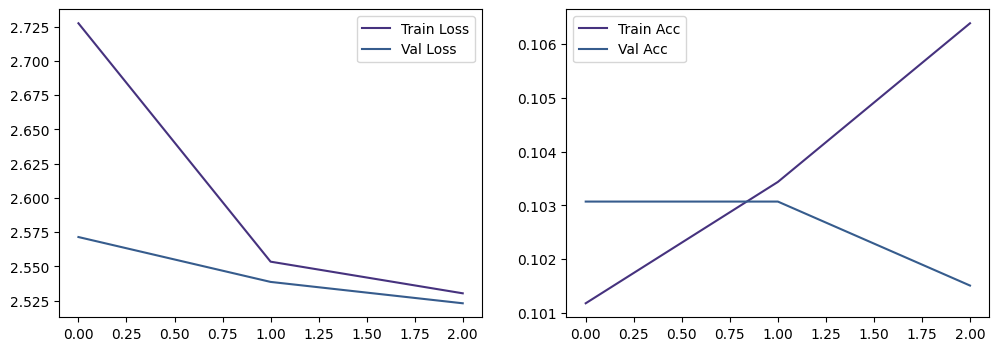

In [53]:
# 5. Plot metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

# 6. Visualise with gradcam
# This is a bit more complex and requires a specific implementation based on your model architecture.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


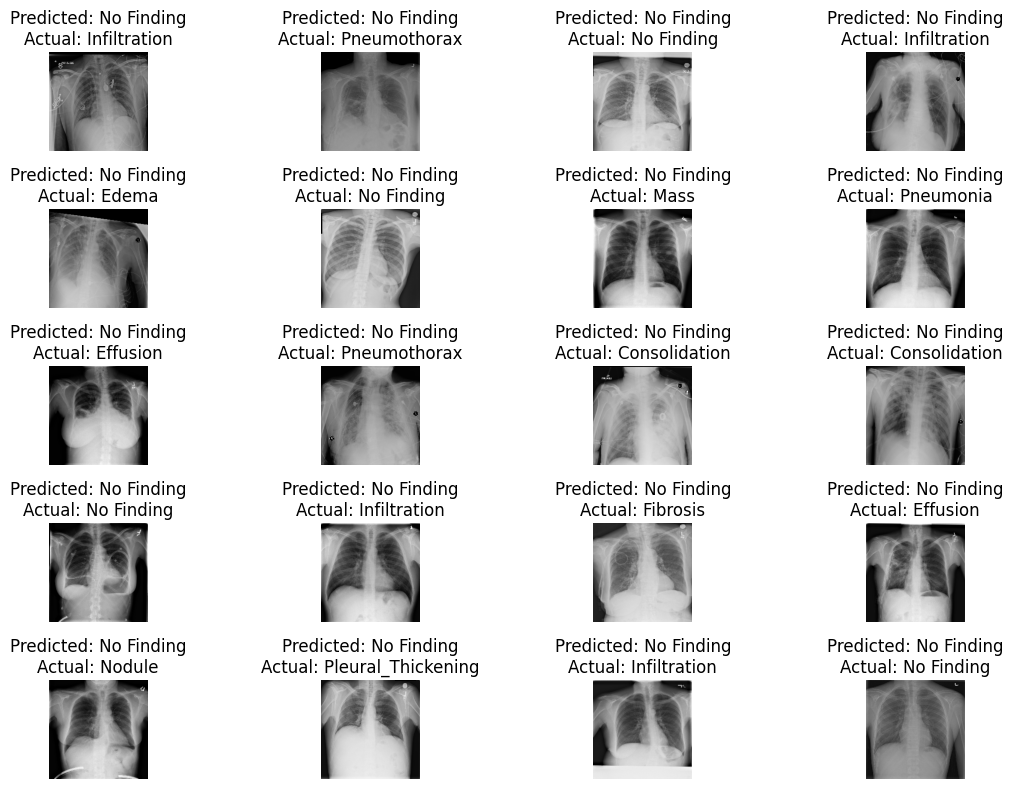

In [54]:
# Get the first batch of images and labels from the training generator
images, labels = next(iter(train_generator))

# Use the model to predict the class probabilities for the images
predictions = model.predict(images)

# Convert the predictions and labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(labels, axis=1)

# Get the class names for the predicted and actual classes
predicted_class_names = [condition_columns[i] for i in predicted_classes]
actual_class_names = [condition_columns[i] for i in actual_classes]

# Plot the images with their predicted and actual classes
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
axes = axes.ravel()

for i in range(len(axes)):
    if i < len(images):
        # Display the image
        axes[i].imshow(images[i])
        axes[i].axis('off')

        # Display the predicted and actual classes
        predicted_class = predicted_class_names[i]
        actual_class = actual_class_names[i]
        axes[i].set_title(f"Predicted: {predicted_class}\nActual: {actual_class}")
    else:
        # Remove any extra subplots
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [55]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.8 MB/s eta 0:00:00


In [56]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from matplotlib import cm
import numpy as np

# Create a Gradcam object
gradcam = Gradcam(model, model_modifier=None, clone=False)

# Define a loss function for Grad-CAM
def loss(output):
    return output  # Use the model output directly as the loss

# Get the first batch of images from the training generator
images, labels = train_generator.next()

# Generate Grad-CAM images
cam_images = gradcam(loss, images)

# Normalize and colormap images
cam_images = normalize(cam_images)
cam_images = cm.jet(cam_images)[..., :3]

# Plot images
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
axes = axes.ravel()

# Limit the number of images to the size of the axes array
num_images = min(len(cam_images), len(axes))

for i in range(num_images):
    im = axes[i].imshow(cam_images[i])
    axes[i].axis('off')

# Add a colorbar
fig.colorbar(im, ax=axes.ravel().tolist())

plt.tight_layout()
plt.show()

ImportError: cannot import name 'Conv' from 'keras.src.layers.convolutional.base_conv' (/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py)